In [3]:
using Statistics: mean

import FFTW

using Interact
using PyPlot

HTML{String}("    <script id=\"webio-setup-323816985277719665\">\n    // Immediately-invoked-function-expression to avoid global variables.\n    (function() {\n        var warning_div = document.getElementById(\"webio-warning-14943226808849853917\");\n        var hide = function () {\n            var script = document.getElementById(\"webio-setup-323816985277719665\");\n            var parent = script && script.parentElement;\n            var grandparent = parent && parent.parentElement;\n            if (grandparent) {\n                grandparent.style.display = \"none\";\n            }\n            warning_div.style.display = \"none\";\n        };\n        if (window.require && require.defined) {\n            // Jupyter notebook.\n            if (require.defined(\"nbextensions/webio/main\")\n                    || require.defined(\"/assetserver/9093b8cc8b7907b7b9e649a9d83d7b6984e8ee13-dist/main.js\")) {\n                // Extension already loaded.\n                hide();\n                return;\n            }\n            console.warn(\"Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).\");\n            require([\"/assetserver/9093b8cc8b7907b7b9e649a9d83d7b6984e8ee13-dist/main.js\"], function (webIOModule) {\n                webIOModule.load_ipython_extension();\n            });\n            warning_div.innerHTML = \"<strong>Loading WebIO Jupyter extension on an ad-hoc basis. Consider enabling the WebIO nbextension for a stabler experience (this should happen automatically when building WebIO).</strong>\";\n        } else if (window.location.pathname.includes(\"/lab\")) {\n            // Guessing JupyterLab\n            warning_div.innerHTML = \"WebIO does not support JupyterLab yet.\";\n        }\n    })();\n    </script>\n    <div\n        id=\"webio-warning-14943226808849853917\"\n        class=\"output_text output_stderr\"\n        style=\"padding: 1em; font-weight: bold;\"\n    >\n        Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n        <!-- TODO: link to installation docs. -->\n    </div>\n")

In [52]:
function solve_poisson_3d_mbc(f, Lx, Ly, Lz)
    Nx, Ny, Nz = size(f)  # Number of grid points (excluding the periodic end point).

    # Forward transform the real-valued source term.
    fh = FFTW.dct(FFTW.rfft(f, [1, 2]), 3)

    # Wavenumber indices.    
    l1 = 0:Int(Nx/2)
    l2 = Int(-Nx/2 + 1):-1
    m1 = 0:Int(Ny/2)
    m2 = Int(-Ny/2 + 1):-1
    n1 = 0:Int(Nz/2)
    n2 = Int(-Nz/2 + 1):-1

    kx = reshape((2π/Lx) * cat(l1, l2, dims=1), (Nx, 1, 1))
    ky = reshape((2π/Ly) * cat(m1, m2, dims=1), (1, Ny, 1))
    kz = reshape((1π/Ly) * cat(n1, n2, dims=1), (1, 1, Nz))

    k² = @. kx^2 + ky^2 + kz^2

    ϕh = - fh ./ k²[1:Int(Nx/2 + 1), :, :]

    # Setting the DC/zero Fourier component to zero.
    ϕh[1, 1, 1] = 0

    # Take the inverse transform of the solution's Fourier coefficients.
    ϕ = FFTW.irfft(FFTW.idct(ϕh, 3), Nx, [1, 2])
end

solve_poisson_3d_mbc (generic function with 1 method)

In [4]:
A = rand(4,4,4)

4×4×4 Array{Float64,3}:
[:, :, 1] =
 0.521928  0.476561  0.236629  0.305972
 0.59484   0.283124  0.259655  0.331654
 0.78182   0.445066  0.343444  0.264773
 0.850227  0.611142  0.752648  0.969383

[:, :, 2] =
 0.762161    0.566845  0.524539   0.845089
 0.891458    0.615295  0.707637   0.899906
 0.475714    0.755312  0.534842   0.378438
 0.00129357  0.391395  0.0793755  0.226022

[:, :, 3] =
 0.550135   0.778756  0.866717  0.774119
 0.0416121  0.866279  0.287318  0.501825
 0.590813   0.204547  0.536858  0.666823
 0.458548   0.38648   0.347895  0.653676

[:, :, 4] =
 0.102067  0.819246  0.47205    0.290854 
 0.873577  0.300231  0.0662235  0.833971 
 0.172723  0.126383  0.774349   0.92057  
 0.65618   0.471205  0.233224   0.0142325

In [42]:
N = 8
A = rand(N, N, N)
Ã1 = FFTW.dct(FFTW.rfft(A, [1, 2]), 3)
Ã2 = FFTW.rfft(FFTW.dct(A, 3), [1, 2])
Ã1 ≈ Ã2

true

In [43]:
N = 8
A = rand(N, N, N)

Ã1 = FFTW.dct(FFTW.rfft(A, [1, 2]), 3)
Ã2 = FFTW.rfft(FFTW.dct(A, 3), [1, 2])

A11 = FFTW.irfft(FFTW.idct(Ã1, 3), N, [1, 2])
A12 = FFTW.idct(FFTW.irfft(Ã1, N, [1, 2]), 3)
A21 = FFTW.irfft(FFTW.idct(Ã2, 3), N, [1, 2])
A22 = FFTW.idct(FFTW.irfft(Ã2, N, [1, 2]), 3)
A ≈ A11 && A ≈ A12 && A ≈ A21 && A ≈ A22

true

In [53]:
Lx, Ly, Lz = 8, 8, 8              # Domain size.
Nx, Ny, Nz = 64, 64, 64           # Number of grid points.
Δx, Δy, Δz = Lx/Nx, Ly/Ny, Lz/Nz  # Grid spacing.

# Grid point locations.
x = Δx * (0:(Nx-1));
y = Δy * (0:(Ny-1));
z = Δz * (0:(Nz-1));

# Primed coordinates to easily calculate a Gaussian centered at
# (Lx/2, Ly/2).
x′ = reshape(x .- Lx/2, (Nx, 1, 1))
y′ = reshape(y .- Ly/2, (1, Ny, 1))
z′ = reshape(z .- Lz/2, (1, 1, Nz))

f = @. 4 * (x′^2 + y′^2 - 1 - (π/Lz)^2) * cos((2π/Lz) * z′) * exp(-(x′^2 + y′^2))  # Source term
f .= f .- mean(f)  # Ensure that source term integrates to zero.

ϕa = @. cos((2π/Lz) * z′) * exp(-(x′^2 + y′^2))  # Analytic solution

ϕs = solve_poisson_3d_mbc(f, Lx, Ly, Lz)

64×64×64 Array{Float64,3}:
[:, :, 1] =
 -0.00386462  -0.00386712  -0.00387459  …  -0.00387459  -0.00386712
 -0.00386712  -0.00386963  -0.00387713     -0.00387713  -0.00386963
 -0.00387459  -0.00387713  -0.00388475     -0.00388475  -0.00387713
 -0.00388699  -0.0038896   -0.00389741     -0.00389741  -0.0038896 
 -0.00390424  -0.00390693  -0.00391501     -0.00391501  -0.00390693
 -0.00392623  -0.00392904  -0.00393747  …  -0.00393747  -0.00392904
 -0.00395283  -0.00395579  -0.00396463     -0.00396463  -0.00395579
 -0.00398387  -0.00398699  -0.00399633     -0.00399633  -0.00398699
 -0.00401913  -0.00402244  -0.00403237     -0.00403237  -0.00402244
 -0.00405838  -0.00406191  -0.00407249     -0.00407249  -0.00406191
 -0.00410133  -0.00410511  -0.00411644  …  -0.00411644  -0.00410511
 -0.00414769  -0.00415174  -0.00416389     -0.00416389  -0.00415174
 -0.00419709  -0.00420144  -0.0042145      -0.0042145   -0.00420144
  ⋮                                     ⋱                          
 -0.00419

In [56]:
# @show size(x)
# @show size(y)
# @show size(f)
# @show minimum(f)
# @show maximum(f)
fig = figure()
@manipulate for n in 1:Nz
    withfig(fig) do
        # PyPlot.contourf(x, y, f[:, :, n], levels=20, vmin=-6, vmax=0.5); PyPlot.colorbar();
        PyPlot.pcolormesh(x, y, f[:, :, n], cmap="bwr", vmin=-4, vmax=4); PyPlot.colorbar();
    end
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:n=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
32), Observable{Int64} with 2 listeners. Value:
32, Scope("knockout-component-ca63a66b-923b-4eac-80db-549361337774", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["n"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>64,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
32, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\Ali\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\Ali\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\Ali\\.julia\\packages\\InteractBase\\Q4IkI\\src\\..\\assets\\all.js", "C:\\Users\\Ali\\.julia\\packages\\InteractBase\\Q4IkI\\src\\..\\assets\\style.css", "C:\\Users\\Ali\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":32}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-ca63a66b-923b-4eac-80db-549361337774\",\"id\":\"ob_51\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-ca63a66b-923b-4eac-80db-549361337774\",\"id\":\"ob_50\",\"type\":\"observable\"},val)) : undefined; return this

In [57]:
@show minimum(ϕs)
@show maximum(ϕs)
@show minimum(ϕa)
@show maximum(ϕa)

minimum(ϕs) = -1.0301367587525077
maximum(ϕs) = 1.0001638920398894
minimum(ϕa) = -1.0
maximum(ϕa) = 1.0


1.0

In [58]:
fig = figure()
@manipulate for n in 1:Nz
    withfig(fig) do
        # PyPlot.contourf(x, y, f[:, :, n], levels=20, vmin=-6, vmax=0.5); PyPlot.colorbar();
        PyPlot.pcolormesh(x, y, ϕs[:, :, n] - ϕa[:, :, n], vmin=-0.5, vmax=0.5, cmap="bwr"); PyPlot.colorbar();
    end
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:n=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
32), Observable{Int64} with 2 listeners. Value:
32, Scope("knockout-component-f87b6226-17be-47d3-a871-dfba348b4252", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["n"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>64,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
32, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\Ali\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\Ali\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\Ali\\.julia\\packages\\InteractBase\\Q4IkI\\src\\..\\assets\\all.js", "C:\\Users\\Ali\\.julia\\packages\\InteractBase\\Q4IkI\\src\\..\\assets\\style.css", "C:\\Users\\Ali\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":32}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-f87b6226-17be-47d3-a871-dfba348b4252\",\"id\":\"ob_58\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-f87b6226-17be-47d3-a871-dfba348b4252\",\"id\":\"ob_57\",\"type\":\"observable\"},val)) : undefined; return this

In [59]:
mean(abs.(ϕs - ϕa))

0.0037849693370245476

In [74]:
Ns = [8, 16, 32, 64, 128, 256]
errors = []
for N in Ns
    Lx, Ly, Lz = 8, 8, 8              # Domain size.
    Nx, Ny, Nz = N, N, N              # Number of grid points.
    Δx, Δy, Δz = Lx/Nx, Ly/Ny, Lz/Nz  # Grid spacing.

    # Grid point locations.
    x = Δx * (0:(Nx-1));
    y = Δy * (0:(Ny-1));
    z = Δz * (0:(Nz-1));

    # Primed coordinates to easily calculate a Gaussian centered at
    # (Lx/2, Ly/2).
    x′ = reshape(x .- Lx/2, (Nx, 1, 1))
    y′ = reshape(y .- Ly/2, (1, Ny, 1))
    z′ = reshape(z .- Lz/2, (1, 1, Nz))

    f = @. 4 * (x′^2 + y′^2 - 1 - (π/Lz)^2) * cos((2π/Lz) * z′) * exp(-(x′^2 + y′^2))  # Source term
    f .= f .- mean(f)  # Ensure that source term integrates to zero.

    ϕa = @. cos((2π/Lz) * z′) * exp(-(x′^2 + y′^2))  # Analytic solution

    ϕs = solve_poisson_3d_mbc(f, Lx, Ly, Lz)
    
    @show N
    @show minimum(ϕs)
    @show maximum(ϕs)
    @show minimum(ϕa)
    @show maximum(ϕa)
    @show mean_error = mean(abs.(ϕs - ϕa))
    append!(errors, mean_error)
end

N = 8
minimum(ϕs) = -1.2092484103972154
maximum(ϕs) = 1.0590654009627474
minimum(ϕa) = -1.0
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.031089741693934313
N = 16
minimum(ϕs) = -1.0988381633427533
maximum(ϕs) = 1.0027195346402635
minimum(ϕa) = -1.0
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.015144764824870705
N = 32
minimum(ϕs) = -1.0562627045838164
maximum(ϕs) = 1.000661839296368
minimum(ϕa) = -1.0
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.007570088842526057
N = 64
minimum(ϕs) = -1.0301367587525077
maximum(ϕs) = 1.0001638920398894
minimum(ϕa) = -1.0
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.0037849693370245476
N = 128
minimum(ϕs) = -1.0156143927198733
maximum(ϕs) = 1.0000409088132491
minimum(ϕa) = -1.0
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.0018924819551114167
N = 256
minimum(ϕs) = -1.007950234880647
maximum(ϕs) = 1.0000102645372686
minimum(ϕa) = -1.0
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.0009462408466507

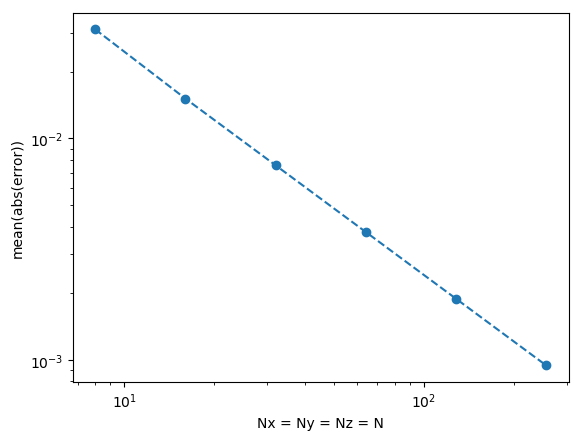

slope = -1.0076174761175745


In [80]:
PyPlot.loglog(Ns, errors, linestyle="--", marker="o");
slope = (log10(errors[end]) - log10(errors[1])) / (log10(Ns[end]) - log10(Ns[1]));
PyPlot.xlabel("Nx = Ny = Nz = N")
PyPlot.ylabel("mean(abs(error))")
@show slope;

In [94]:
Ns = [8, 16, 32, 64, 128, 256]
errors = []
for N in Ns
    Lx, Ly, Lz = 8, 8, 8              # Domain size.
    Nx, Ny, Nz = N, N, N              # Number of grid points.
    Δx, Δy, Δz = Lx/Nx, Ly/Ny, Lz/Nz  # Grid spacing.

    # Grid point locations.
    x = Δx * (0:(Nx-1));
    y = Δy * (0:(Ny-1));
    z = Δz * (0:(Nz-1));

    # Primed coordinates to easily calculate a Gaussian centered at
    # (Lx/2, Ly/2).
    x′ = reshape(x .- Lx/2, (Nx, 1, 1))
    y′ = reshape(y .- Ly/2, (1, Ny, 1))
    z′ = reshape(z .- Lz/2, (1, 1, Nz))

    f = @. ( 4*(x′^2 + y′^2 - 1) - (π/(2*Lz))^2) * cos((π/2*Lz) * z′) * exp(-(x′^2 + y′^2))  # Source term
    f .= f .- mean(f)  # Ensure that source term integrates to zero.

    ϕa = @. cos((π/(2*Lz)) * z′) * exp(-(x′^2 + y′^2))  # Analytic solution

    ϕs = solve_poisson_3d_mbc(f, Lx, Ly, Lz)
    ϕs .= ϕs .- minimum(ϕs)
    
    @show N
    @show minimum(ϕs)
    @show maximum(ϕs)
    @show minimum(ϕa)
    @show maximum(ϕa)
    @show mean_error = mean(abs.(ϕs - ϕa))
    append!(errors, mean_error)
end

N = 8
minimum(ϕs) = 0.0
maximum(ϕs) = 1.0898136684033521
minimum(ϕa) = 8.954917337833549e-15
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.016071919775989915
N = 16
minimum(ϕs) = 0.0
maximum(ϕs) = 1.0270682982954928
minimum(ϕa) = 8.954917337833549e-15
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.011136613902096838
N = 32
minimum(ϕs) = 0.0
maximum(ϕs) = 1.9338152225570275
minimum(ϕa) = 8.954917337833549e-15
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.9327254717523104
N = 64
minimum(ϕs) = 0.0
maximum(ϕs) = 0.22363159026001872
minimum(ϕa) = 8.954917337833549e-15
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.12220012061931321
N = 128
minimum(ϕs) = 0.0
maximum(ϕs) = 0.13343721159712454
minimum(ϕa) = 8.954917337833549e-15
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.08146274512652298
N = 256
minimum(ϕs) = 0.0
maximum(ϕs) = 0.09134507707315692
minimum(ϕa) = 8.954917337833549e-15
maximum(ϕa) = 1.0
mean_error = mean(abs.(ϕs - ϕa)) = 0.06865052524

In [90]:
@show minimum(ϕs)
@show maximum(ϕs)
@show minimum(ϕa)
@show maximum(ϕa)
ϕs .= ϕs .- minimum(ϕs)
 @show mean(abs.(ϕs - ϕa))

minimum(ϕs) = 0.0
maximum(ϕs) = 1.0147424961375815
minimum(ϕa) = 7.754564901785182e-31
maximum(ϕa) = 1.0
mean(abs.(ϕs - ϕa)) = 0.01889949869856986


0.01889949869856986

In [88]:
fig = figure()
@manipulate for n in 1:Nz
    withfig(fig) do
        # PyPlot.contourf(x, y, f[:, :, n], levels=20, vmin=-6, vmax=0.5); PyPlot.colorbar();
        PyPlot.pcolormesh(x, y, ϕs[:, :, n], vmin=-0.5, vmax=0.5, cmap="bwr"); PyPlot.colorbar();
    end
end

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:n=>Widget{:slider,Int64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:value=>Observable{Int64} with 2 listeners. Value:
32), Observable{Int64} with 2 listeners. Value:
32, Scope("knockout-component-f8287fc9-7450-4e4f-a7ef-28566c0dfc9f", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["n"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>64,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: value, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"value"=>(Observable{Int64} with 2 listeners. Value:
32, nothing)), Set(String[]), nothing, Any["knockout"=>"C:\\Users\\Ali\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout.js", "knockout_punches"=>"C:\\Users\\Ali\\.julia\\packages\\Knockout\\JIqpG\\src\\..\\assets\\knockout_punches.js", "C:\\Users\\Ali\\.julia\\packages\\InteractBase\\Q4IkI\\src\\..\\assets\\all.js", "C:\\Users\\Ali\\.julia\\packages\\InteractBase\\Q4IkI\\src\\..\\assets\\style.css", "C:\\Users\\Ali\\.julia\\packages\\InteractBulma\\Ohu5Y\\src\\..\\assets\\main.css"], Dict{Any,Any}("_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"changes\\\":0,\\\"value\\\":32}\");\n    var self = this;\n    function AppViewModel() {\n        for (var key in json_data) {\n            var el = json_data[key];\n            this[key] = Array.isArray(el) ? ko.observableArray(el) : ko.observable(el);\n        }\n        \n        \n        [this[\"changes\"].subscribe((function (val){!(this.valueFromJulia[\"changes\"]) ? (WebIO.setval({\"name\":\"changes\",\"scope\":\"knockout-component-f8287fc9-7450-4e4f-a7ef-28566c0dfc9f\",\"id\":\"ob_86\",\"type\":\"observable\"},val)) : undefined; return this.valueFromJulia[\"changes\"]=false}),self),this[\"value\"].subscribe((function (val){!(this.valueFromJulia[\"value\"]) ? (WebIO.setval({\"name\":\"value\",\"scope\":\"knockout-component-f8287fc9-7450-4e4f-a7ef-28566c0dfc9f\",\"id\":\"ob_85\",\"type\":\"observable\"},val)) : undefined; return this